# Imports

In [1]:
import pandas as pd
import numpy as np
from langdetect import detect
import matplotlib.pyplot as plt
import seaborn as sbn
plt.style.use("seaborn")

C:\Users\leopo\AppData\Local\Temp\ipykernel_11584\2608210481.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


In [2]:
import spotiscience as sps

# Credentials

In [ ]:
# create a dictionary with authorization keys
# we can use sps.credentials
CREDENTIALS = {}
CREDENTIALS['client_id'] = client_id
CREDENTIALS['client_secret'] = client_secret
CREDENTIALS['redirect_url'] = redirect_url
CREDENTIALS['user_id'] = userid
CREDENTIALS['genius_access_token'] = genius_access_token # genius is optional, only

# Downloader

In [3]:
"""You also can set your credentials id on credentials.py and import from spotiscience"""

# returns 'downloader class'
sd = sps.downloader.SpotiScienceDownloader(credentials=sps.credentials.CREDENTIALS)


# Example on a whole playlist : downloading and extracting data

### Downloading

In [18]:
from importlib import reload
reload(sps)

<module 'spotiscience' from 'c:\\Users\\leopo\\OneDrive - GENES\\AutomatedPlaylistMaking\\automated-playlist-making-1\\spotiscience\\__init__.py'>

In [19]:
playlists = sps.PLAYLISTS

In [5]:
sp = sps.SpotiSciencePredicter()

In [6]:
languages = sp.languages
len_playlist_max = 50

In [ ]:
playlist_data = {}
playlists_id = {}

In [21]:
#Return song features of playlists

try:
    for playlist in playlists:
        data = sd.get_playlist_song_features(playlist_id=playlist,n_songs=len_playlist_max)
        name = list(data.keys())[0]
        playlists_id[name] = playlists
        playlist_data[name] = data[name]
except Exception as e:
    print(playlist)
    print(e)

Playlist Dreampop downloaded!
Playlist French 90s RAP downloaded!
Playlist Synthwave downloaded!
Playlist Dream House downloaded!
Playlist Electropolis downloaded!
Playlist American 90's Rap downloaded!


In [23]:
whole_data = []
for name in playlist_data.keys():
    whole_data += playlist_data[name]
df_playlist = pd.DataFrame.from_records(whole_data)
df_playlist.to_pickle("df_playlist_brute.pkl")

### mood prediction, getting genres

In [24]:
for name in playlist_data.keys():
    for song in playlist_data[name]:

        mood = sp.predict_song_mood(song=song)
        song['mood'] = str(mood)

        song['original playlist'] = name
        song['original playlist id'] = playlists_id[name]

        genre = sd.get_song_music_genre(song_id=song['id'])
        song['genre'] = genre
    
    

c:\Users\leopo\anaconda3\envs\spotify\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.24.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\leopo\anaconda3\envs\spotify\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\leopo\anaconda3\envs\spotify\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.1.3. This might lead 

### getting lyrics and their topics

In [25]:
for name in playlist_data.keys():
    for song in playlist_data[name]:
        #create error : juste relaunch it at the same place it stops
        #linked to get_feature_name
        try:
            lyrics = sd.get_song_lyrics(songname=song['name'],artistname=song['artist'])
        except (TimeoutError, ConnectionError, ConnectionAbortedError, ConnectionRefusedError, Exception) as e:
            print(e, song['name']," we set it has no lyrics")
            lyrics = ''
        song['lyrics'] = lyrics
        if lyrics == '':
            song['has_lyrics'] = False
            song['topics'] = []
            song['lang'] = None
        else:
            song['has_lyrics'] = True
            model = 'lda' # (available type 'lda', 'lsi', 'nmf')
            lang = detect(lyrics)
            
            if not lang in languages.keys():
                #language of the song not yet supported, feel free to add it
                song['topics'] = []
            else:
                lang = languages[lang] # (available type 'english','spanish', 'french', 'german')
                song['lang'] = lang
                # check for the last one.
                # using langdetect detect function to identify the language
                # need to had a error gestion regarding the language, if the lyrics can't be identify in those
                # or install the core relevant to the language
                #default parameter
                n_grams = (1,1)
                n_topics = 10
                top_n = 1
                try:
                    topics = sp.predict_topic_lyric(lyrics,model,lang,n_grams,n_topics,top_n)
                    list_topic=[]
                    list_coef = []
                    for nb in topics:
                        for topic in topics[nb][0]:
                            list_topic.append(topic[0])
                            list_coef.append(topic[1])
                    song['topics_brut']=topics
                    song['topics'] = list_topic
                    song['topics_coeff'] = list_coef
                except AttributeError as e:
                    print(e, "set to no topics")
                    song['topics'] = []
                

Searching for "If I Ever Feel Better" by Phoenix...
Done.


c:\Users\leopo\anaconda3\envs\spotify\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Searching for "What You Know" by Two Door Cinema Club...
Done.
Searching for "Heal Tomorrow" by Naive New Beaters...
Done.
Searching for "The Look" by Metronomy...
Done.
Searching for "Amour plastique" by Videoclub...
Done.
Searching for "Electric Feel" by MGMT...
Done.
Searching for "Photomaton" by Jabberwocky...
Done.
Searching for "Loud Places" by Jamie xx...
Done.
Searching for "Playground Love" by Air...
Done.
Searching for "Retrograde" by James Blake...
Done.
Searching for "Summertime Sadness" by Lana Del Rey...
Done.
Searching for "Le temps est bon" by Bon Entendeur...
Done.
Searching for "Feels Like We Only Go Backwards" by Tame Impala...
Done.
Searching for "Down The Road" by C2C...
Done.
Searching for "My Number" by Foals...
Done.
Searching for "Toop Toop" by Cassius...
Done.
Searching for "Happy Man" by Jungle...
Done.
Searching for "La vague" by Izïa...
Done.
Searching for "Clint Eastwood" by Gorillaz...
Request timed out:
HTTPSConnectionPool(host='genius.com', port=443): R

In [26]:
whole_data = []
for name in playlist_data.keys():
    whole_data += playlist_data[name]

In [27]:
df_playlist = pd.DataFrame.from_records(whole_data)

In [30]:
print("nb tracks : ", len(df_playlist['topics']), "Number of tracks missing topics due to timeout :",len(df_playlist[[len(t)==0 for t in df_playlist['topics']]]) )


nb tracks :  212 Number of tracks missing topics due to timeout : 20


#### Sauvegarde

In [28]:
df_playlist.to_pickle("df_playlist.pkl")

In [ ]:
df_playlist = pd.read_pickle("df_playlist.pkl")

### Genre summarization

##### What genre do we have

In [29]:
collected_genre = df_playlist['genre'].sum()

<AxesSubplot: >

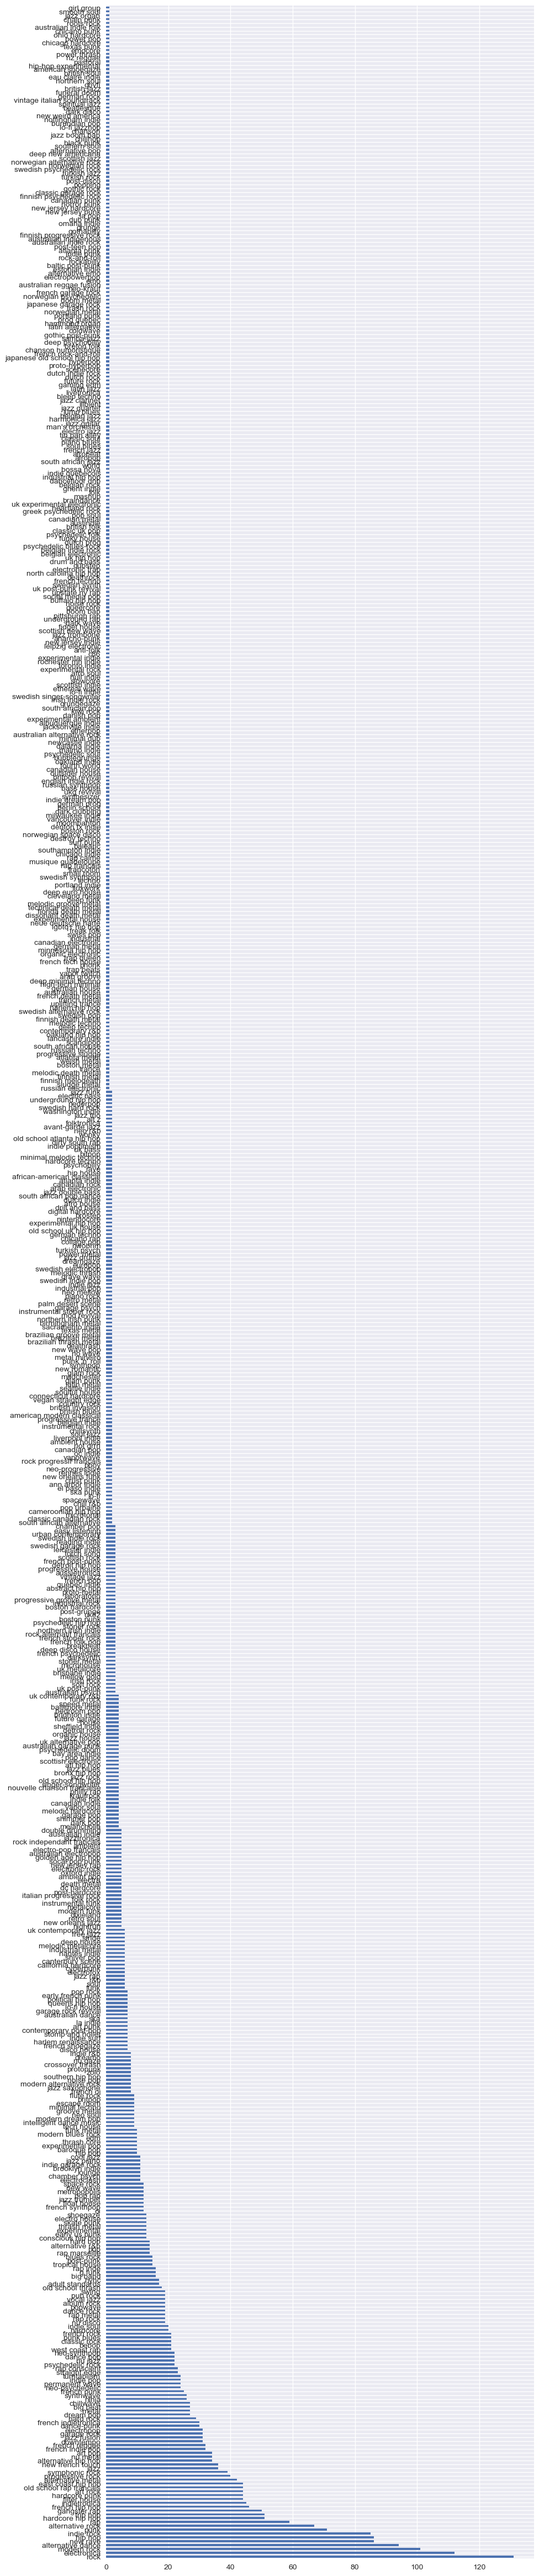

In [30]:
fig = plt.figure()
fig.set_size_inches(10,60)
pd.Series(collected_genre).value_counts().plot.barh()

Problem : too much genres to be comprehensive

On retient en genre les suivants :
- jazz
- funk
- pop
- electronica
- house
- dream
- synth
- rock
- progressive
- experimental
- punk
- alternative
- modern
- dance
- rap
- indie
- french
- hip hop


In [31]:
selfdefined_genre = ['jazz','funk','pop','electronica','techno','house','synth','dream',
'rock','progressive','experimental','alternative','modern','dance','rap','french','indie','hip hop','metal','punk']
for genre in selfdefined_genre:
    df_playlist[genre+' dummy'] = ''
    df_playlist[genre+' score'] = ''

In [32]:
sp = sps.SpotiSciencePredicter()

In [33]:
cols_scores = {}
for genre in selfdefined_genre:
    cols_scores[genre] = []
for song in df_playlist.iterrows():
    score = sp.calculate_genres_links(selfdefined_genre,song[1])
    for genre in selfdefined_genre:
        cols_scores[genre].append(score[genre])
for genre in selfdefined_genre:
    df_playlist[genre+' score'] = cols_scores[genre]

c:\Users\leopo\OneDrive - GENES\AutomatedPlaylistMaking\automated-playlist-making-1\spotiscience\prediction.py:307: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  s = token.similarity(tk)


In [34]:
# identification for every song
selfdefined_tags = {'jazz':'jazz','funk':'funk',
'pop':'pop','electronica':'elec','techno':'techno','house':'house',
'synth':'synth','dream':'dream','rock':'rock',
'progressive':'prog','experimental':'exp','alternative':'alt','modern':'modern',
'dance':'dance','rap':'rap','french':'franc,frenc','indie':'ind',
'hip hop':'hip,hop','metal':'metal','punk':'punk'}
for genre in selfdefined_genre:
    col_genre = []
    for song_genre in df_playlist['genre']:
        subgenre = selfdefined_tags[genre].split(',')
        b = False
        for sub in subgenre:
            for song_subgenre in song_genre:
                b = b or (sub in song_subgenre) #we test if in the str of the genre of the song we find an occurence of our subgenre
        col_genre.append(b)
    df_playlist[genre+" dummy"] = col_genre


### Similarities

In [41]:
for i in range(2):
    print(i, df_playlist.iloc[i]['topics'], df_playlist.iloc[i]['topics_coeff'], df_playlist.iloc[i]['lang'])

0 ['know', 'feel', 'tell', 'time', 'like', 'try', 'good', 'number', 'remind', 'spend'] [13.04779373051797, 9.843101762724942, 8.228183408246966, 7.446913433280885, 6.641853583182735, 6.632408985130626, 6.630428557298426, 5.845869394632877, 5.795164080332283, 5.79507010012319] english
1 ['know', 'want', 'time', 'yeah', 'tell', 'like', 'right', 'try', 'eye', 'test'] [9.864600679651174, 9.018297542008634, 7.455241893056964, 3.4143104010160017, 3.397942362794269, 2.6198297930706858, 2.6067152950351193, 2.5923184319466275, 2.586921973453819, 1.8309048817737352] english


In [42]:
print(sp.calculate_topics_similarities(df_playlist.iloc[0],df_playlist.iloc[1]))

0.610039535250496


### Sauvegarde

In [ ]:
# sauvegarde avec ajout
# df_playlist_old = pd.read_pickle("df_playlist.pkl")

In [35]:
# sauvegarde avec suppression
df_playlist.to_pickle("df_playlist.pkl")

In [4]:
# récupération
df_playlist = pd.read_pickle("df_playlist.pkl")

# Data pour analyse

In [46]:
objective = "original playlist"
vars = ['has_lyrics','mood','popularity', 'length',
       'acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'valence', 'loudness', 'speechiness', 'tempo', 'key',
       'time_signature'] + [genre+' dummy' for genre in selfdefined_genre] +[genre+' score' for genre in selfdefined_genre]

In [73]:
df_playlist_complete = df_playlist[[objective]+vars].dropna()

In [78]:
Y = df_playlist_complete[objective]
X = df_playlist_complete[vars]
X.replace(True,0, inplace=True)
X.replace(False,1, inplace=True)
X['mood'].replace('energy',1, inplace=True)
X['mood'].replace('happy', 0.75, inplace=True)
X['mood'].replace('calm',0.5, inplace=True)
X['mood'].replace('sad',0.25, inplace=True)

C:\Users\leopo\AppData\Local\Temp\ipykernel_11584\2162100589.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.replace(True,0, inplace=True)
C:\Users\leopo\AppData\Local\Temp\ipykernel_11584\2162100589.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.replace(False,1, inplace=True)
C:\Users\leopo\AppData\Local\Temp\ipykernel_11584\2162100589.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['mood'].replace('energy',1, inpla

# Classification

In [85]:
from sklearn import svm
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import seaborn as sns

In [80]:
X.dropna(inplace = True)
sc = StandardScaler()
sc.fit(X)
X_std = sc.transform(X)

X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_std, Y, test_size=0.2, shuffle=True)


C:\Users\leopo\AppData\Local\Temp\ipykernel_11584\2026464913.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.dropna(inplace = True)


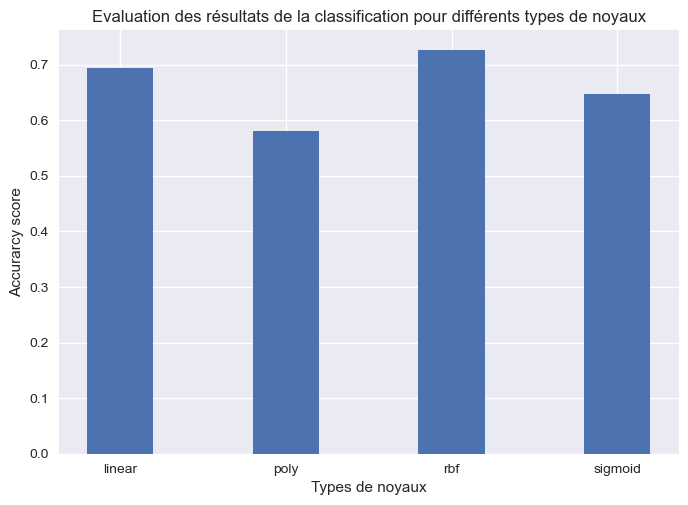

In [81]:
# Résultats
resultats = []
liste_noyaux = ['linear', 'poly', 'rbf', 'sigmoid'] 

for noyaux in liste_noyaux :                
    # Entrainement 
    model = SVC(kernel= noyaux, random_state=1, C=1.0)
    model.fit(X_train, Y_train)
    # Résultats
    Y_pred = model.predict(X_test)
    resultats.append(accuracy_score(Y_test, Y_pred))

# Présentation des résultats
plt.bar(liste_noyaux, resultats, width=0.4)
plt.xlabel("Types de noyaux")
plt.ylabel("Accurarcy score")
plt.title("Evaluation des résultats de la classification pour différents types de noyaux")
plt.show()

In [82]:
noyau_accurate = liste_noyaux[np.array(resultats).argmax()]
model = SVC(kernel= noyau_accurate, random_state=1, C=1.0)
model.fit(X_train, Y_train)
# Résultats
Y_pred = model.predict(X_test)

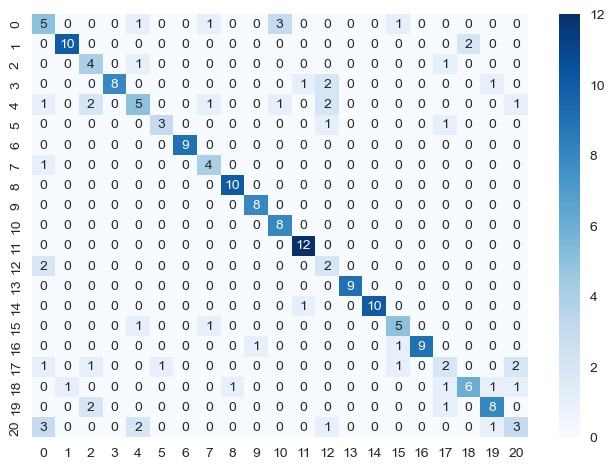

In [86]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(Y_test, Y_pred)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

# Clustering
see [scikit-learn website](https://scikit-learn.org/stable/modules/clustering.html) for more information on the different clustering methods

In [506]:
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

In [507]:
df_playlist.keys()

Index(['id', 'name', 'artist', 'album', 'release_date', 'popularity', 'length',
       'acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'valence', 'loudness', 'speechiness', 'tempo', 'key',
       'time_signature', 'mood', 'genre', 'has_lyrics', 'topics', 'jazz,funk',
       'pop', 'electro,tronica', 'techno,club', 'house', 'synth,dream', 'rock',
       'prog,exp', 'alt,modern', 'dance,rave', 'rap', 'franc, french', 'ind',
       'hip,hop', 'metal'],
      dtype='object')

In [508]:
numvar = ['popularity', 'length',
       'acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'valence', 'loudness', 'speechiness', 'tempo']
categorical_var = ['mood','artist']+selfdefined_genre
list_var = ['genre','topics']
df_clustering = df_playlist[numvar+categorical_var+list_var]
# a question can be ask about popularity


## Numeric Only Clustering

In [282]:
df_clustering[numvar].sample(3)

,popularity,length,acousticness,danceability,energy,instrumentalness,liveness,valence,loudness,speechiness,tempo
660,28,200693,0.00327,0.484,0.903,0.001260,0.106,0.2220,-4.235,0.0803,133.107
533,0,254266,0.38300,0.369,0.396,0.000001,0.115,0.5760,-13.926,0.0668,205.947
366,43,124265,0.98100,0.506,0.259,0.972000,0.528,0.0774,-14.279,0.0349,111.753


c:\Users\leopo\anaconda3\envs\spotify\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\leopo\anaconda3\envs\spotify\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\leopo\anaconda3\envs\spotify\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\leopo\anaconda3\envs\spotify\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarn

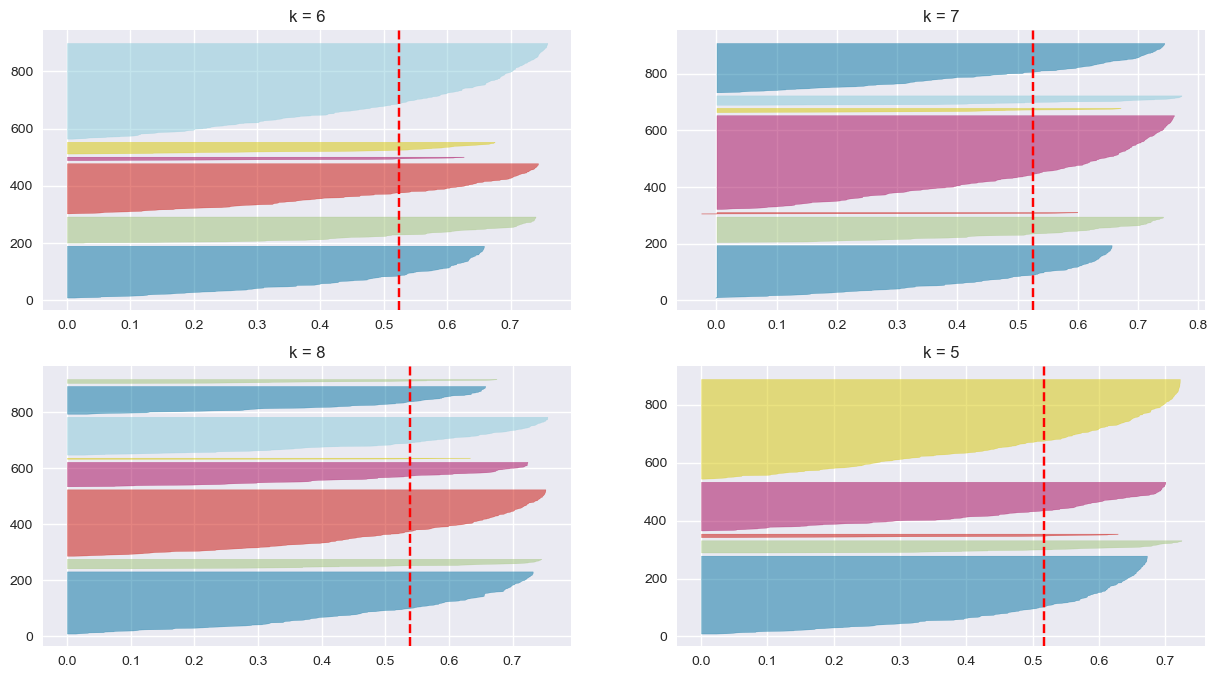

In [283]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(2, 2, figsize=(15,8))
j=0
for i in [5,6,7,8]:#[3, 4, 6, 10]:
    j += 1
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(j, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    ax[q-1][mod].set_title("k = " + str(i))
    visualizer.fit(df_clustering[numvar])


## Numeric and Categorical clustering

Since we made a lot of work to predic a mood and some genre, we must try to use those categorical variables, which we can't do with K-Means.
So first I based the following code on [Jorge Martin Lasaosa post](https://towardsdatascience.com/clustering-on-numerical-and-categorical-features-6e0ebcf1cbad) about Gower Distance, check it out.

Gower distance $ ps_{ij}^{(f)} $ between $i$ and $j$ for the variable $f$ is : 
- for a numeric type : $ ps_{ij}^{(f)} = 1 - |x_{if}-x_{jf}|/R_{f} $ avec $ R_f = \max f - \min f $
- For a categorical feature, the partial similarity between two individuals is one only when both observations have exactly the same value for this feature. Zero otherwise.

Code inspired by this [post](https://www.thinkdatascience.com/post/2019-12-16-introducing-python-package-gower/).

In [509]:
import gower
# we compute this distance explained above


Extension to custom distance matrix :
- if it's a numeric or a categorical feature, use Gower distance
- if it's a list, use Jaccard distance.

Here we are going to use Jaccard distance to measure distance of the brute genres and brutes topics. We also calculate Jaccard distance for a vector of the selected genres.
[Jaccard distance](https://flavien-vidal.medium.com/similarity-distances-for-natural-language-processing-16f63cd5ba55) is defined for a subset A and B (here represented by a list) by :

$d_J(A,B) = 1 - J(A,B)$ where $J(A,B)$ is the Jaccard index defined by :

$J(A,B) = card(A \cap B) / card(A \cup B)$ = proportion of common points

The code is inspired by this [Statology post](https://www.statology.org/jaccard-similarity-python/)

In [510]:
#define Jaccard Similarity function
def jaccard(list1, list2):
    if len(list1+list2) == 0:
        return 1
    else:
        intersection = len(list(set(list1).intersection(list2)))
        union = (len(list1) + len(list2)) - intersection
        return float(intersection) / union       
def jaccard_dissimilarity_matrix(df):
    n = len(df)
    matrix = np.zeros((n,n))
    for i in range(n):
        for j  in range(i):
            d = 1 - jaccard(df.iloc[i],df.iloc[j])
            matrix[i,j] = d
            matrix[j,i] = d
    return matrix

def custom_distance_matrix(df_clustering):
    """the idea is to do an extension of the gower distance with the defined custom distance
    since the final distance matrix is the mean of each dissimilarity matrix we will use the distance matrix to compute for 
    numerical and categorical and compute our own matrix to compute for list var"""
    distance_matrix = gower.gower_matrix(df_clustering[numvar+categorical_var])
    distance_matrix = len(numvar+categorical_var)*distance_matrix
    for var in list_var:
        distance_matrix += jaccard_dissimilarity_matrix(df_clustering[var])
    distance_matrix = distance_matrix/len(numvar+categorical_var+list_var)
    return distance_matrix

In [511]:
distance_matrix = custom_distance_matrix(df_clustering)

In [512]:
(distance_matrix<0).any() or (distance_matrix>1).any()

False

### With clustering DBScan

In [438]:
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import DBSCAN

#km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
dbscan_cluster = DBSCAN(eps=0.11, 
                    min_samples=2, 
                    metric="precomputed")
q, mod = divmod(j, 2)
'''
Create SilhouetteVisualizer instance with KMeans instance
Fit the visualizer
'''
visualizer = SilhouetteVisualizer(dbscan_cluster, colors='yellowbrick', ax=ax[q-1][mod])
ax[q-1][mod].set_title("k = " + str(i))
dbscan_cluster.fit(distance_matrix)


DBSCAN(eps=0.11, metric='precomputed', min_samples=2)

In [439]:
df_clustering["cluster"] = dbscan_cluster.labels_

C:\Users\leopo\AppData\Local\Temp\ipykernel_1072\2529867548.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clustering["cluster"] = dbscan_cluster.labels_


Number of clusters :

(-1 = outliers)

In [440]:
df_clustering['cluster'].nunique()

94

Number of song by cluster

In [441]:
for i in range(-1, df_clustering['cluster'].nunique()):
    print(len(df_clustering[df_clustering['cluster']==i]), end=', ')

371, 7, 24, 18, 12, 2, 3, 10, 2, 32, 19, 2, 2, 18, 2, 2, 17, 3, 6, 2, 2, 3, 2, 3, 5, 2, 7, 10, 2, 2, 3, 2, 12, 3, 2, 5, 3, 4, 4, 2, 3, 4, 2, 2, 2, 2, 4, 3, 2, 2, 3, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 4, 2, 2, 2, 2, 2, 6, 8, 24, 9, 3, 6, 4, 9, 29, 4, 3, 5, 2, 2, 2, 2, 2, 2, 3, 0, 

Mostly a failure : the first cluster is too big, which is coherent, DBScan is made for outliers spotting

###  AffinityPropagation
Trying with another clustering methods : AffinityPropagation. Results are corrects

In [513]:
#from sklearn.cluster import SpectralClustering essayé fonctionne très mal
from sklearn.cluster import AffinityPropagation

Examples : we can set a series of examples

In [514]:
examples_id = ['6z4n862KhNJNWDYSn4aLL5','7uv632EkfwYhXoqf8rhYrg','1GMQEnykhAyTLwkIViTFQk','16tvIGzCNfRLVbm8G39DDo',
'5mY8mY7DSfuqVbY2psq3Cg','6jkN2vp6rSP1WMlPJVlWQB','6TSDRzJGwbK9cajVbtqlPV','56iv5TqfvxVa4zLMs6SvmP','0cx1vZcndRhwSDgR8NtEfk',
'4h33lJL2YU05kEMaSkao47','7Fe3ZwOjTVppElF4TMfxNP','46WOptLnXUtH3LOyYvmMO1','4Ztvl8C9Ld3IdHNo1a3UBe','5N7NLLGdrTy4QYuyM6ewm0','2Y0iGXY6m6immVb2ktbseM',
'3gcmn2CtOE9SjBevmvGVEk','2mcMoXYHmVLxmCgAvaO2cS','3XZssUmtDdhFK1tZJasgXD']

In [517]:
len(examples_id)

18

In [516]:
examples_index = list(df_playlist.loc[df_playlist['id'].isin(examples_id)].index)
preferences = np.zeros(len(df_clustering))
for i in examples_index:
    preferences[i]=1/len(examples_id)

In [519]:
#choosen_model = KMeans(n_clusters=10, init='k-means++', n_init=10, max_iter=2000, random_state=100)# 200,42
choosen_model = AffinityPropagation(damping = 0.5, affinity='precomputed', max_iter=1000,preference=preferences)
# idée assigné des points au musique en fonction de mon nombre d'écoute => voir la doc dans preference

In [520]:
results = choosen_model.fit(distance_matrix)

In [521]:
df_clustering['cluster'] = results.labels_

C:\Users\leopo\AppData\Local\Temp\ipykernel_1072\674743309.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clustering['cluster'] = results.labels_


### Analysing results

Number of clusters : (and in the idea the number of playlist)

In [522]:
df_clustering['cluster'].nunique()

8

How many songs by playlist :

In [523]:
for i in range(10):
    print(f"For the cluster {i}, there are {len(df_clustering[df_clustering['cluster']==i])} songs")


For the cluster 0, there are 26 songs
For the cluster 1, there are 87 songs
For the cluster 2, there are 146 songs
For the cluster 3, there are 26 songs
For the cluster 4, there are 44 songs
For the cluster 5, there are 81 songs
For the cluster 6, there are 112 songs
For the cluster 7, there are 132 songs
For the cluster 8, there are 0 songs
For the cluster 9, there are 0 songs


What kind of characteristics has each cluster : 

In [524]:
df_clustering.groupby('cluster').sum()

C:\Users\leopo\AppData\Local\Temp\ipykernel_1072\1973429802.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_clustering.groupby('cluster').sum()


,popularity,length,acousticness,danceability,energy,instrumentalness,liveness,valence,loudness,speechiness,...,"synth,dream",rock,"prog,exp","alt,modern","dance,rave",rap,"franc, french",ind,"hip,hop",metal
cluster,,,,,,,,,,,,,,,,,,,,,
0,1022,7917274,4.648865,15.477,17.760,13.132740,4.8988,10.2804,-230.810,1.4661,...,2,1,1,1,1,0,10,7,1,0
1,3688,18805819,15.329890,60.473,61.668,9.096052,18.8360,54.3579,-588.974,5.8961,...,16,7,1,9,40,2,20,51,0,1
2,5054,32097519,38.386445,92.101,93.124,17.153746,22.5706,70.1075,-1091.419,12.1765,...,3,5,8,8,4,2,24,11,12,2
3,931,7637084,4.353243,16.936,17.751,12.072810,5.1209,12.7451,-220.873,1.6404,...,2,4,1,1,1,0,4,6,2,0
4,1761,10500129,11.194448,26.994,25.651,1.654152,7.0460,17.5038,-366.477,5.3666,...,7,11,0,1,1,0,14,39,0,0
5,3429,20655703,8.057240,50.991,61.809,17.760683,12.9126,48.9950,-516.440,4.3888,...,23,66,7,67,45,1,1,77,1,0
6,5771,28509611,11.603267,61.482,85.839,15.109553,21.0211,45.9235,-633.386,5.7820,...,22,61,1,75,60,1,1,78,1,0
7,7027,29922503,7.613011,78.663,107.868,7.438676,35.3592,82.4103,-727.435,10.8726,...,1,86,2,107,43,1,7,50,11,7


We can also see for each cluster what is the central track

In [525]:
df_playlist.iloc[results.cluster_centers_indices_]

,id,name,artist,album,release_date,popularity,length,acousticness,danceability,energy,...,"synth,dream",rock,"prog,exp","alt,modern","dance,rave",rap,"franc, french",ind,"hip,hop",metal
111,26JkaeeVVIPLquHEsf7YJd,Summertime Clothes,Animal Collective,Merriweather Post Pavilion,2009-01-10,36,274213,0.001640,0.491,0.871,...,True,True,True,True,True,False,False,True,False,False
186,4m3M6l513rITHvn9LaKJeA,The Final Thing on My Mind,The Pineapple Thief,Your Wilderness,2016-08-12,40,593604,0.015600,0.357,0.497,...,False,True,True,True,False,False,False,False,False,True
320,27MJQKKDik4a8KSPpktTJ0,Lights & Music,Cut Copy,In Ghost Colours,2008-01-01,43,277386,0.073500,0.603,0.946,...,True,True,False,True,True,False,False,True,False,False
340,26JkaeeVVIPLquHEsf7YJd,Summertime Clothes,Animal Collective,Merriweather Post Pavilion,2009-01-10,36,274213,0.001640,0.491,0.871,...,True,True,True,True,True,False,False,True,False,False
354,6PSRMbqr5se9zwl5iOYOA8,Poney Pt. I,Vitalic,OK Cowboy,2005-04-04,41,323000,0.000824,0.580,0.718,...,False,False,False,True,True,False,False,False,False,False
417,7H9csL7dKKKe2YvnuhppGe,Gangster moderne,MC Solaar,Paradisiaque / Mc Solaar,2021-12-03,36,245826,0.066700,0.762,0.575,...,False,False,False,False,False,True,True,False,True,False
418,24PxaqIrZ3cujSNRQDBa6m,Bouge de là - Part. 1,MC Solaar,Bouge de là,1991,41,191466,0.043100,0.814,0.606,...,False,False,False,False,False,True,True,False,True,False
582,4SohcSzXceGEWTwp9Q9vwk,Océan rouge,Flavien Berger,Mars balnéaire,2014-06-23,41,827586,0.522000,0.570,0.258,...,True,False,False,False,False,False,False,True,False,False


# Adding for each cluster a playlist and let's see if it's correct in any way (probably not), need a chromium based web browser as default browser
(or at least crash on firefox)

In [526]:
nb_playlist = df_clustering['cluster'].nunique()

In [300]:
"""U2FsdGVkX1/Dr36Htbd0NHeSyt7zcwtOQAlJhOZtI448GRilIUDqUXbG2VcrJ3P9vptgDzKVDtdT4Oem
8or4aSpWtATxKVoPB0zFaiDwvO9xGZ3LMmczFu4VdpSm41KwAVd47tUU3rB6GYnBfBbLgglun0vTKlp0
EkSa+Nf8A3paQIcCKVIjvQFD4jUyIdqucqh+De+Q83QfBXsawCoByXTbVrMeA+KClO6eFO5yvh8cc0GS
Xa/ulwOiGLIZR94ZatZNG4HHOHdPnFlJ5VS48olv0FzUV9tXom/9omdtF+Qm2nragQ30nfMQUG4q56Dl
D2bCxpM7LHcqUeyt8rtDCGKvLKm3Op17OJ3mgCDQpRpXFc+fqJCyKXhEglMOJ4g2gox4xvBtCVtPlKsp
9HLO2GKPXO9GsFGmYlGtVkMm1ZqfAR90tWZvfYWNUBI5ZlffvB9VGmsRi4zoM+LyETIhJtEtPOUG0NVO
/I1pVHy20yGBZC4/szf8/NUnbf0Njelz4gc6oppflk2fDeZn5pr5Zl38rL81G/Ev2gmm476UXdE="""

'U2FsdGVkX1/Dr36Htbd0NHeSyt7zcwtOQAlJhOZtI448GRilIUDqUXbG2VcrJ3P9vptgDzKVDtdT4Oem\n8or4aSpWtATxKVoPB0zFaiDwvO9xGZ3LMmczFu4VdpSm41KwAVd47tUU3rB6GYnBfBbLgglun0vTKlp0\nEkSa+Nf8A3paQIcCKVIjvQFD4jUyIdqucqh+De+Q83QfBXsawCoByXTbVrMeA+KClO6eFO5yvh8cc0GS\nXa/ulwOiGLIZR94ZatZNG4HHOHdPnFlJ5VS48olv0FzUV9tXom/9omdtF+Qm2nragQ30nfMQUG4q56Dl\nD2bCxpM7LHcqUeyt8rtDCGKvLKm3Op17OJ3mgCDQpRpXFc+fqJCyKXhEglMOJ4g2gox4xvBtCVtPlKsp\n9HLO2GKPXO9GsFGmYlGtVkMm1ZqfAR90tWZvfYWNUBI5ZlffvB9VGmsRi4zoM+LyETIhJtEtPOUG0NVO\n/I1pVHy20yGBZC4/szf8/NUnbf0Njelz4gc6oppflk2fDeZn5pr5Zl38rL81G/Ev2gmm476UXdE='

In [527]:
#create a dictionary with authorization keys
CREDENTIALS = {}
CREDENTIALS['client_id'] = client_id
CREDENTIALS['client_secret'] = client_secret
CREDENTIALS['redirect_url'] = redirect_url
CREDENTIALS['user_id'] = userid
CREDENTIALS['genius_access_token'] = genius_access_token # genius is optional, only

"""You also can set your credentials id on credentials.py and import from spotiscience"""

# returns 'downloader class'
sd = sps.downloader.SpotiScienceDownloader(credentials=CREDENTIALS)


In [528]:
from importlib import reload

In [529]:
reload(sps.downloader)

<module 'spotiscience.downloader' from 'c:\\Users\\leopo\\OneDrive - GENES\\SpotifyProject\\Examples-playlist-making\\spotiscience-1\\spotiscience\\downloader.py'>

In [530]:
sd = sps.downloader.SpotiScienceDownloader(credentials=CREDENTIALS)

In [531]:
nb_playlist

8

In [533]:
for i in range(nb_playlist):
    song_ids =[]
    for id in df_playlist[df_clustering['cluster']==i]['id']:
        song_ids.append("spotify:track:"+id)
    sd.add_playlist(f"AffinityPropagation Cluster V3 {i}",song_ids)

Creating with scope :  playlist-modify-public the playlist :  AffinityPropagation Cluster V3 0
Creating with scope :  playlist-modify-public the playlist :  AffinityPropagation Cluster V3 1
Creating with scope :  playlist-modify-public the playlist :  AffinityPropagation Cluster V3 2
Creating with scope :  playlist-modify-public the playlist :  AffinityPropagation Cluster V3 3
Creating with scope :  playlist-modify-public the playlist :  AffinityPropagation Cluster V3 4
Creating with scope :  playlist-modify-public the playlist :  AffinityPropagation Cluster V3 5
Creating with scope :  playlist-modify-public the playlist :  AffinityPropagation Cluster V3 6
Creating with scope :  playlist-modify-public the playlist :  AffinityPropagation Cluster V3 7


In [ ]:
# idée d'amélioration possible mettre moins de poids à certaines choses en faisant moi même la moyenne 